Classificação de Fake News com Machine Learning

Esse projeto visa análisar, buscar padrões e criar um modelo de machine learning que consiga classificar uma noticia como falsa usando seu conteúdo como base. Para isso usaremos as bilbiotecas pandas, numpy, nltk, scukit-learn, seaborn e matplotlib

In [2]:
from collections import Counter
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

Para fazermos as analizes, importamos os pacotes do NLTK para remoção de stopwords

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rpjun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rpjun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rpjun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# importção dos dados que serão utilizados no projeto
df_eval = pd.read_csv('datasets/evaluation.csv', sep=';')
df_train = pd.read_csv('datasets/train.csv', sep=';')
df_test = pd.read_csv('datasets/test.csv', sep=';')

Analisando os bancos de dados, identificamos que as noticias são classificadas em 4 categorias, sendo elas: 0 -> notícia falsa e 1 -> notícia verdadeira.

In [4]:
# 1 = True; 0 = False

df_eval.head()

,,title,text,label
0,0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1.0
1,1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1.0
2,2,Oregon Cop Convicted Of Shattering Biker’s Col...,"In a baffling fit of rage, an Oregon State Pol...",0.0
3,3,Twitter Erupts With Glee Over #CruzSexScandal ...,The last thing any politician running for the ...,0.0
4,4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0.0


In [5]:
df_train.head()
# df_test.head()

,Unnamed: 0,title,text,label
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24353 non-null  int64 
 1   title       24353 non-null  object
 2   text        24353 non-null  object
 3   label       24353 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 761.2+ KB


In [7]:
df_train.shape

(24353, 4)

Para analisarmos as noticias falsas, dividimos o dataset principal em dois datasets menores

In [8]:
df_false = df_train[df_train['label'] == 0]
df_true = df_train[df_train['label'] == 1]

In [9]:
df_true['lenght'] = df_true['text'].apply(len)

In [10]:
df_true.describe()

,Unnamed: 0,label,lenght
count,13246.000000,13246.0,13246.000000
mean,12186.042503,1.0,2426.448060
std,7051.037427,0.0,1885.303065
min,0.000000,1.0,4.000000
25%,6106.250000,1.0,919.000000
50%,12188.000000,1.0,2213.000000
75%,18342.500000,1.0,3272.000000
max,24348.000000,1.0,32584.000000


Criando um hitograma para visualizar a distribuição dos textos falsos, vemos que a grande maioria dos textos falsos tem menos de 5000 caracteres.

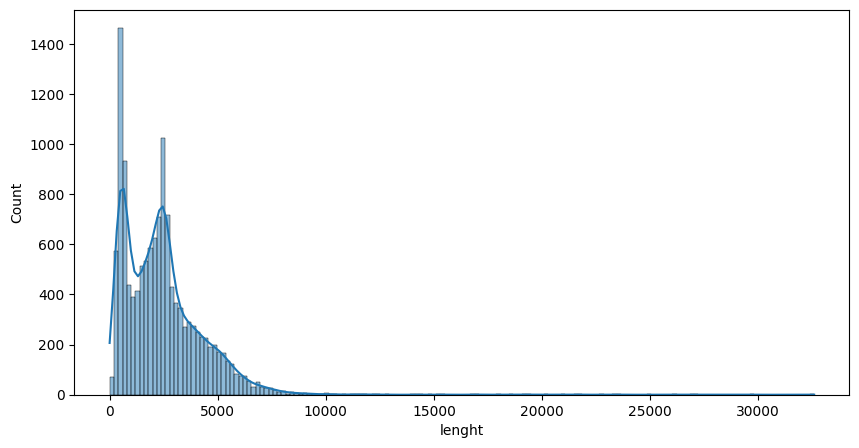

In [11]:
fig= plt.subplots(figsize=(10, 5))
sns.histplot(df_true['lenght'], kde=True)
plt.show()

In [4]:
# Função usada para limpar o texto
def limpar_texto(texto):
    texto = re.sub(r'<.*?>', '', texto)  # Remove tags HTML
    texto = re.sub(r'http\S+', '', texto)  # Remove URLs
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)  # Remove caracteres especiais
    texto = texto.lower()  # Converte para minúsculas
    texto = texto.strip()  # Remove espaços extras

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    tokens = word_tokenize(texto.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]

    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

In [5]:
# Função validar qual o melhor modelo para esse dataset

def fValidaModelo(models , X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Validação cruzada para avaliar desempenho
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1_Score = f1_score(y_test, y_pred)
        precision_Score = precision_score(y_test, y_pred)
        recall_Score = recall_score(y_test, y_pred)
        results[name] = {
            "Cross-Validation Score (Mean)": np.mean(cv_scores),
            "Acurácia": round(accuracy * 100,2),
            "f1 score": f1_Score,
            "precision score": precision_Score,
            "recall score" : recall_Score
        }
    return results

In [97]:
def fSalvaModelo(df, models, method):
    best_model_name = df["f1 score"].idxmax()
    best_model = models[best_model_name]
    filename = f"best_model_{method}_{best_model_name.replace(' ', '_').lower()}.pkl"
    joblib.dump(best_model, filename)
    print(f"Melhor modelo salvo como: {filename}")

In [15]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()


Criamos uma nova feature chamada clean_text e aplicamos a função limpar_texto para limpar o texto de cada linha.

In [16]:
df_train_copy['clean_text'] = df_train_copy['text'].apply(limpar_texto)

In [17]:
df_train_copy

,Unnamed: 0,title,text,label,clean_text
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1,ramallah west bank reuters palestinian switche...
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1,beijing reuters u presidentelect donald trump ...
2,2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0,controversy trump personal tax return continue...
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1,beijing reuters trip beijing last week zimbabw...
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0,ha never uncourageous person white house barac...
...,...,...,...,...,...
24348,24348,Mexico Senate committee OK's air transport dea...,MEXICO CITY (Reuters) - A key committee in Mex...,1,mexico city reuters key committee mexico senat...
24349,24349,BREAKING: HILLARY CLINTON’S STATE DEPARTMENT G...,IF SHE S NOT TOAST NOW THEN WE RE IN BIGGER TR...,0,toast bigger trouble thought much whole thing ...
24350,24350,trump breaks from stump speech to admire beaut...,kremlin nato was created for agression \nruss...,0,kremlin nato wa created agression russia today...
24351,24351,NFL PLAYER Delivers Courageous Message: Stop B...,Dallas Cowboys star wide receiver Dez Bryant t...,0,dallas cowboy star wide receiver dez bryant to...


Durante a análise, percebemos que a coluna label esta organizada de que os valores fiquem agrupados, então para evitar que o modelo aprenda de forma errada, vamos embaralhar os dados. 

In [18]:
df_train_copy =  shuffle(df_train_copy)

Para a primeira abordagem, vamos utilizar o modelo de Bag of Words (BoW) para vetorizar o texto. O BoW é uma técnica que converte texto em vetores de palavras, onde cada palavra é representada por um número inteiro. A contagem de palavras é feita por meio da função CountVectorizer do scikit-learn.

In [19]:
vectorizer = CountVectorizer()

In [20]:
X = vectorizer.fit_transform(df_train_copy['clean_text'])
y = df_train_copy['label']

In [21]:
# Divisão do dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Criação do dicionário de modelos
models = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": MultinomialNB()
}

Após a validação do modelo, a melhor performance foi obtida com o modelo Support Vector Machine, com um f1 score de 0.97. Após isso, o modelo foi salvo para uso posterior, além de ser validado com dados de um dataset diferente. 

In [24]:
results =  fValidaModelo(models, X_train, y_train, X_test, y_test)
results_df = pd.DataFrame(results).T
results_df

,Cross-Validation Score (Mean),Acurácia,f1 score,precision score,recall score
Random Forest,0.959039,95.79,0.961704,0.956166,0.967306
Support Vector Machine,0.973565,97.29,0.974809,0.990306,0.959790
Logistic Regression,0.975054,97.54,0.977341,0.982163,0.972567
Decision Tree,0.974387,97.15,0.973857,0.974774,0.972943
K-Nearest Neighbors,0.742378,75.57,0.785663,0.754410,0.819617
Naive Bayes,0.933991,93.23,0.938225,0.934726,0.941751


In [99]:
fSalvaModelo(results_df, models, "count_vectorizer")

Melhor modelo salvo como: best_model_count_vectorizer_logistic_regression.pkl


In [26]:
with open('best_model_logistic_regression.pkl', 'rb') as f_model:
    modelo = joblib.load(f_model)

In [77]:
texto_1 = df_test['text'][1]
texto_2 = df_test['text'][8116]


In [82]:
X = vectorizer.transform([limpar_texto(texto_1)])

In [83]:
modelo.predict(X)

array([1])

In [84]:
X_2 = vectorizer.transform([limpar_texto(texto_2)])

In [85]:
modelo.predict(X_2)

array([0])

Para a segunda parte do projeto, foi utilizado o TfidfVectorizer, que é uma técnica de processamento de linguagem natural que converte texto em vetores de números reais, onde cada número representa a importância de uma palavra em relação ao texto.

In [86]:
tfidf_vectorizer = TfidfVectorizer()

In [87]:
X_tfidf = tfidf_vectorizer.fit_transform(df_train_copy['clean_text'])
y_tfidf = df_train_copy['label']

In [90]:
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

Para essa abordagem, o modelo com melhor performance foi o RDecision Tree, com um f1 score de 0.97. Como no caso anterior, o modelo foi salvo para uso posterior.

In [92]:
results_tfidf = fValidaModelo(models, X_tfidf_train, y_tfidf_train, X_tfidf_test, y_tfidf_test)
results_df_tfidf = pd.DataFrame(results_tfidf).T

In [94]:
results_df_tfidf

,Cross-Validation Score (Mean),Acurácia,f1 score,precision score,recall score
Random Forest,0.960579,95.71,0.960781,0.959520,0.962044
Support Vector Machine,0.970537,97.13,0.973424,0.983506,0.963548
Logistic Regression,0.965045,96.57,0.968437,0.974144,0.962796
Decision Tree,0.973976,97.45,0.976648,0.978860,0.974446
K-Nearest Neighbors,0.543733,56.09,0.333852,0.974545,0.201428
Naive Bayes,0.895853,89.74,0.911190,0.863927,0.963923


In [98]:
fSalvaModelo(results_df_tfidf, models, "tfidf")

Melhor modelo salvo como: best_model_tfidf_decision_tree.pkl


In [100]:
with open('best_model_tfidf_decision_tree.pkl', 'rb') as f_model_2:
    modelo_2 = joblib.load(f_model_2)

In [103]:
X_new_1 = tfidf_vectorizer.transform([limpar_texto(texto_1)])
X_new_2 = tfidf_vectorizer.transform([limpar_texto(texto_2)])

In [104]:
modelo_2.predict(X_new_1)

array([1])

In [105]:
modelo_2.predict(X_new_2)

array([0])

Observações

Para o dataset escolhido, ambas abordagens tiveram uma performance aceitável, entretanto, a abordagem de BoW teve um tempo menos de treino e validação, em torno de 40 minutos. Já a abordagem de TF-IDF teve um tempo de treino e validação em torno de 1 hora e 30 minutos.